In [4]:
# BOX 1: imports
import os

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms, datasets

import numpy as np

from IPython.display import Image as IPyImage

import matplotlib.pyplot as plt
%matplotlib inline


In [6]:
import os
print(os.getcwd()) 


/Users/amirhamza/Documents/Fall 2025/Machine Learning/Projects/Project 3


In [2]:
# BOX 2: load Razorback image folders
data_root = './data' 

train_dir = os.path.join(data_root, 'train')
valid_dir = os.path.join(data_root, 'valid')
test_dir  = os.path.join(data_root, 'test')

basic_transform = transforms.Compose([
    transforms.Resize([500, 500]),
    transforms.ToTensor()
])

razor_train_dataset_raw = datasets.ImageFolder(train_dir, transform=basic_transform)
razor_valid_dataset_raw = datasets.ImageFolder(valid_dir, transform=basic_transform)
razor_test_dataset_raw  = datasets.ImageFolder(test_dir,  transform=basic_transform)

print("Classes:", razor_train_dataset_raw.classes) 
print('Train set:', len(razor_train_dataset_raw))
print('Validation set:', len(razor_valid_dataset_raw))
print('Test set:', len(razor_test_dataset_raw))


Classes: ['non_razorback', 'razorback']
Train set: 36
Validation set: 8
Test set: 6


In [3]:
# BOX 3: visualize
torch.manual_seed(1)

fig = plt.figure(figsize=(12, 6))

for i, (img, label) in enumerate(razor_train_dataset_raw):
    ax = fig.add_subplot(2, 5, i + 1)
    ax.imshow(img.permute(1, 2, 0))
    ax.set_xticks([])
    ax.set_yticks([])
    class_name = razor_train_dataset_raw.classes[label]
    ax.set_title(class_name, fontsize=10)
    
    if i == 9:
        break

plt.tight_layout()
plt.show()


UnidentifiedImageError: cannot identify image file <_io.BufferedReader name='./data/train/non_razorback/il_765x1020.1732176539_24db.png'>

In [8]:
# BOX 4: define transforms 
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize([500, 500]), 
    transforms.ToTensor(),
])

transform_eval = transforms.Compose([
    transforms.Resize([500, 500]), 
    transforms.ToTensor(),
])


In [9]:
# BOX 5: recreate datasets using final transforms
razor_train_dataset = datasets.ImageFolder(train_dir, transform=transform_train)
razor_valid_dataset = datasets.ImageFolder(valid_dir, transform=transform_eval)
razor_test_dataset  = datasets.ImageFolder(test_dir,  transform=transform_eval)

torch.manual_seed(1)
batch_preview_loader = DataLoader(razor_train_dataset, batch_size=2, shuffle=True)


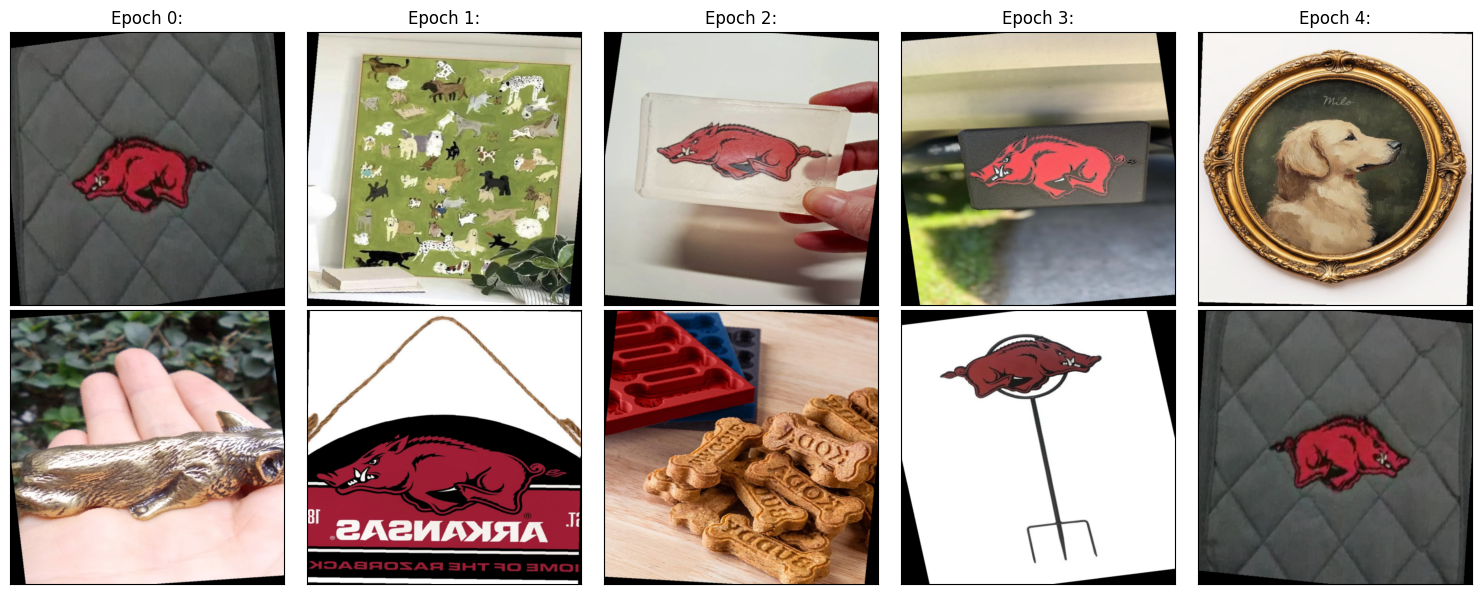

In [10]:
# BOX 6: visualize changes images over epochs
fig = plt.figure(figsize=(15, 6))

num_epochs_vis = 5
for j in range(num_epochs_vis):
    img_batch, label_batch = next(iter(batch_preview_loader))
    
    img = img_batch[0]
    ax = fig.add_subplot(2, 5, j + 1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'Epoch {j}:', size=12)
    ax.imshow(img.permute(1, 2, 0))
    
    img = img_batch[1]
    ax = fig.add_subplot(2, 5, j + 6)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(img.permute(1, 2, 0))

plt.tight_layout()
plt.show()


In [11]:
# BOX 8: using full data so not going to subset small set 
from torch.utils.data import Subset

# razor_train_dataset = Subset(razor_train_dataset, torch.arange(len(razor_train_dataset)))
# razor_valid_dataset = Subset(razor_valid_dataset, torch.arange(len(razor_valid_dataset)))
print('Train set:', len(razor_train_dataset))
print('Validation set:', len(razor_valid_dataset))


Train set: 36
Validation set: 8


In [12]:
# BOX 9: data loaders
batch_size = 8 

torch.manual_seed(1)
train_dl = DataLoader(razor_train_dataset, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(razor_valid_dataset, batch_size=batch_size, shuffle=False)
test_dl  = DataLoader(razor_test_dataset,  batch_size=batch_size, shuffle=False)


In [13]:
# BOX 10: CNN model (Razorback vs Non-Razorback)
model = nn.Sequential()

model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1))
model.add_module('relu1', nn.ReLU())
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))
model.add_module('dropout1', nn.Dropout(p=0.5))

model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1))
model.add_module('relu2', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))
model.add_module('dropout2', nn.Dropout(p=0.5))

model.add_module('conv3', nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1))
model.add_module('relu3', nn.ReLU())
model.add_module('pool3', nn.MaxPool2d(kernel_size=2))

model.add_module('conv4', nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1))
model.add_module('relu4', nn.ReLU())


In [14]:
# BOX 11: check shape after current conv/pool stack
x = torch.ones((4, 3, 500, 500))
with torch.no_grad():
    out = model(x)
print("Shape after conv blocks:", out.shape)


Shape after conv blocks: torch.Size([4, 256, 62, 62])


In [15]:
# BOX 12: add global pooling and flatten
model.add_module('gap', nn.AdaptiveAvgPool2d((1, 1))) 
model.add_module('flatten', nn.Flatten())      

# check size again
x = torch.ones((4, 3, 500, 500))
with torch.no_grad():
    out = model(x)
print("Shape after gap + flatten:", out.shape)


Shape after gap + flatten: torch.Size([4, 256])


In [16]:
# BOX 13: fully connected + sigmoid
model.add_module('fc', nn.Linear(256, 1))
model.add_module('sigmoid', nn.Sigmoid())


In [17]:
# BOX 14: final model output shape check
x = torch.ones((4, 3, 500, 500))
with torch.no_grad():
    out = model(x)
print("Final output shape:", out.shape)


Final output shape: torch.Size([4, 1])


In [18]:
# BOX 15: print model architecture
model


Sequential(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.5, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU()
  (gap): AdaptiveAvgPool2d(output_size=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [19]:
# BOX 16: move model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
device


device(type='cpu')

In [20]:
# BOX 17: loss function and optimizer
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [21]:
# BOX 18: training function
def train(model, num_epochs, train_dl, valid_dl, device=device):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs

    for epoch in range(num_epochs):
        # training
        model.train()
        for x_batch, y_batch in train_dl:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            pred = model(x_batch)[:, 0]          
            loss = loss_fn(pred, y_batch.float()) 

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            loss_hist_train[epoch] += loss.item() * y_batch.size(0)

            is_correct = ((pred >= 0.5).float() == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum().cpu()

        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)

        # validation
        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)

                pred = model(x_batch)[:, 0]
                loss = loss_fn(pred, y_batch.float())

                loss_hist_valid[epoch] += loss.item() * y_batch.size(0)
                is_correct = ((pred >= 0.5).float() == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum().cpu()

        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)

        print(
            f'Epoch {epoch+1} '
            f'accuracy: {accuracy_hist_train[epoch]:.4f} '
            f'val_accuracy: {accuracy_hist_valid[epoch]:.4f}'
        )

    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid


In [22]:
# BOX 19: run training
torch.manual_seed(1)

num_epochs = 10 
hist = train(model, num_epochs, train_dl, valid_dl)


Epoch 1 accuracy: 0.5000 val_accuracy: 0.5000
Epoch 2 accuracy: 0.5000 val_accuracy: 0.5000
Epoch 3 accuracy: 0.5000 val_accuracy: 0.5000
Epoch 4 accuracy: 0.5000 val_accuracy: 0.5000
Epoch 5 accuracy: 0.5000 val_accuracy: 0.5000
Epoch 6 accuracy: 0.5556 val_accuracy: 0.6250
Epoch 7 accuracy: 0.4722 val_accuracy: 0.5000
Epoch 8 accuracy: 0.5000 val_accuracy: 0.5000
Epoch 9 accuracy: 0.5000 val_accuracy: 0.5000
Epoch 10 accuracy: 0.5278 val_accuracy: 0.6250


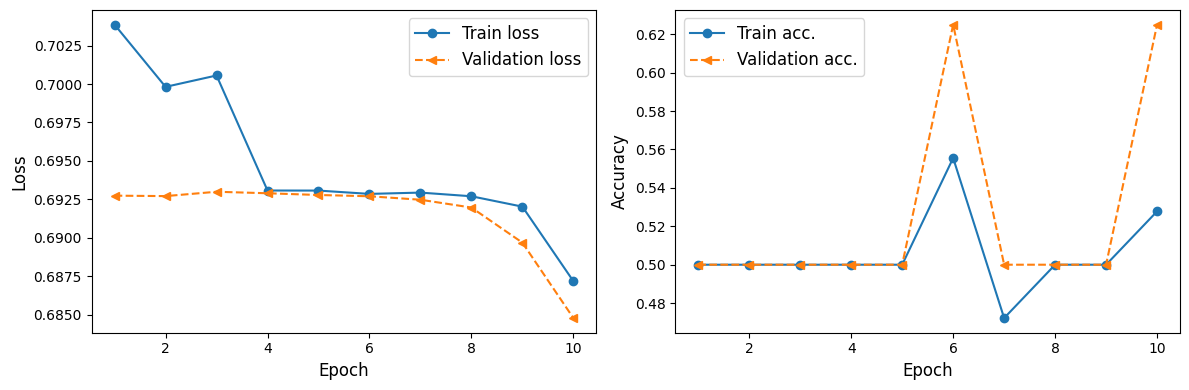

In [23]:
# BOX 20: plot train/validation loss and accuracy
x_arr = np.arange(len(hist[0])) + 1

fig = plt.figure(figsize=(12, 4))

ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.legend(fontsize=12)
ax.set_xlabel('Epoch', size=12)
ax.set_ylabel('Loss', size=12)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train acc.')
ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
ax.legend(fontsize=12)
ax.set_xlabel('Epoch', size=12)
ax.set_ylabel('Accuracy', size=12)

plt.tight_layout()
plt.show()


In [24]:
# BOX 21: evaluate on test set
accuracy_test = 0
model.eval()

with torch.no_grad():
    for x_batch, y_batch in test_dl:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        pred = model(x_batch)[:, 0]
        is_correct = ((pred >= 0.5).float() == y_batch).float()
        accuracy_test += is_correct.sum().cpu()

accuracy_test /= len(test_dl.dataset)
print(f'Test accuracy: {accuracy_test:.4f}')


Test accuracy: 0.5000


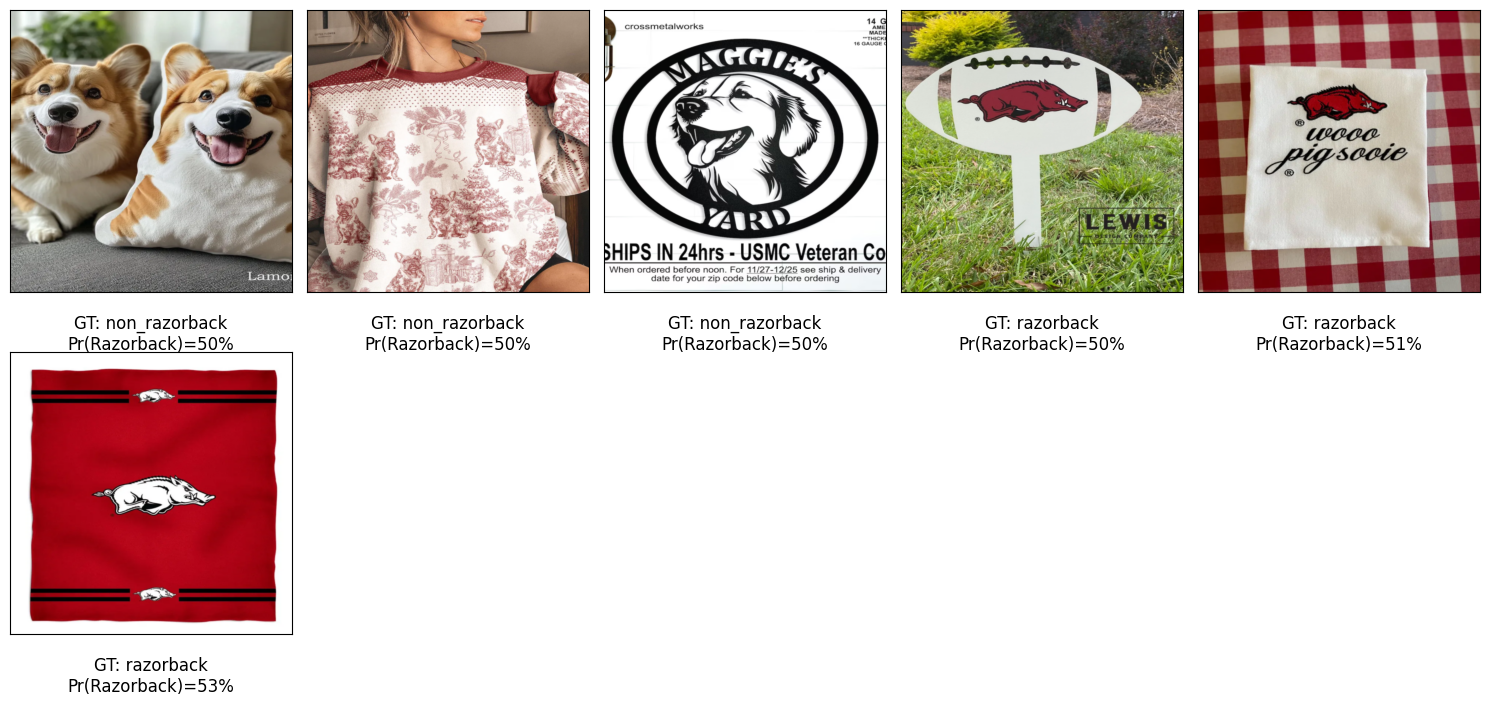

In [25]:
# BOX 22: visualize probabilities for a batch
model.eval()
x_batch, y_batch = next(iter(test_dl))
x_batch = x_batch.to(device)

with torch.no_grad():
    prob = model(x_batch)[:, 0] * 100

fig = plt.figure(figsize=(15, 7))

num_show = min(10, x_batch.size(0))
for j in range(num_show):
    ax = fig.add_subplot(2, 5, j + 1)
    ax.set_xticks([])
    ax.set_yticks([])

    img_cpu = x_batch[j].cpu().permute(1, 2, 0)
    ax.imshow(img_cpu)

    gt_label = razor_test_dataset.classes[y_batch[j]]
    pred_prob = prob[j].item()
    ax.text(
        0.5, -0.15,
        f'GT: {gt_label}\nPr(Razorback)={pred_prob:.0f}%',
        size=12,
        horizontalalignment='center',
        verticalalignment='center',
        transform=ax.transAxes
    )

plt.tight_layout()
plt.show()


In [29]:
# BOX 23: save

path = f'Group_14_CNN_FullModel.ph'

torch.save(model, path)
print("Saved model to:", path)


Saved model to: Group_14_CNN_FullModel.ph


In [27]:
# BOX 24: reload full model
load_path = f'models/Group_14_CNN_FullModel.ph'

loaded_full_model = torch.load(load_path, weights_only=False)
loaded_full_model = loaded_full_model.to(device)
loaded_full_model.eval()


Sequential(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.5, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU()
  (gap): AdaptiveAvgPool2d(output_size=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)